## Benchmark logistic regression on speech recognition

In [4]:
!pip install scikit-learn

  Using cached scikit_learn-0.23.0-cp38-cp38-manylinux1_x86_64.whl (7.2 MB)
     |████████████████████████████████| 298 kB 2.5 MB/s eta 0:00:01
  Using cached threadpoolctl-2.0.0-py3-none-any.whl (34 kB)


In [10]:
# File utilities
import glob 
import os.path

import numpy as np

# To read spectrograms
from scipy import signal
from scipy.io import wavfile

# To resize spectrograms
import cv2 # Normal resizing
import skimage.measure # Max pooling

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import skimage.measure
from scipy.io import wavfile
from scipy import signal
from sklearn.model_selection import train_test_split
import glob

# Shuffling data
import random

In [11]:
def create_spectrogram(file_name, window_size=20, step_size=10, eps=1e-10):
    """Creates a spectrogram from audio file"""
    sample_rate, audio = wavfile.read(file_name)
    
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio,  fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)

    # Create log spectrogram
    spectrogram = np.log(spec.astype(np.float32) + eps)

    # Max pooling
    spectrogram = skimage.measure.block_reduce(spectrogram, (13, 13), np.max)
    
    # Resize to 8x8 and flatten
    spectrogram = cv2.resize(spectrogram, (8,8), cv2.INTER_CUBIC).flatten()

    return spectrogram

In [12]:
def speech_mnist(phase='train'):
    print("Creating speech_mnist dataset")
    X = np.empty((2350*10, 64))
    y = np.empty((2350*10))
    numbers = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
    for n, number in enumerate(numbers):
        paths = glob.glob(f"../datasets/speech_mnist/{number}/*.wav")
        paths = sorted(paths)
        for i, path in enumerate(paths):
            X[n*2350+i,:] = create_spectrogram(path).flatten()
            y[n*2350+i] = n
    Xtr, Xte, ytr, yte = train_test_split(X,y,test_size=0.2,random_state=123)
  
    return Xtr, ytr.astype(np.uint8), Xte, yte.astype(np.uint8)
    

In [13]:
X_tr, y_tr, X_te, y_te = speech_mnist()

Creating speech_mnist dataset


/home/andrew/Desktop/old-wann/wann-nlp-old/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc: 0.2177


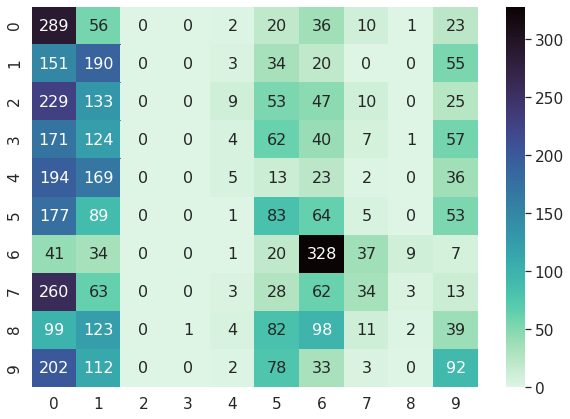

In [94]:
model = LogisticRegression(max_iter=0, random_state=3)
model.fit(X_tr, y_tr)
preds = model.predict(X_te)
print(f"Test acc: {np.mean(preds == y_te):.4f}")
cf = list(confusion_matrix(y_te, preds).astype(int))
df = pd.DataFrame(cf, range(10), range(10))
sn.set(font_scale=1.4)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True, annot_kws={'size': 16}, fmt='g', cmap=sn.cm.mako_r)
plt.show()

In [80]:
sn.cm.

<module 'matplotlib.colors' from '/home/andrew/Desktop/old-wann/wann-nlp-old/venv/lib/python3.8/site-packages/matplotlib/colors.py'>

In [63]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

In [65]:
df

,0,1,2,3,4,5,6,7,8,9
0,289,56,0,0,2,20,36,10,1,23
1,151,190,0,0,3,34,20,0,0,55
2,229,133,0,0,9,53,47,10,0,25
3,171,124,0,0,4,62,40,7,1,57
4,194,169,0,0,5,13,23,2,0,36
5,177,89,0,0,1,83,64,5,0,53
6,41,34,0,0,1,20,328,37,9,7
7,260,63,0,0,3,28,62,34,3,13
8,99,123,0,1,4,82,98,11,2,39
9,202,112,0,0,2,78,33,3,0,92


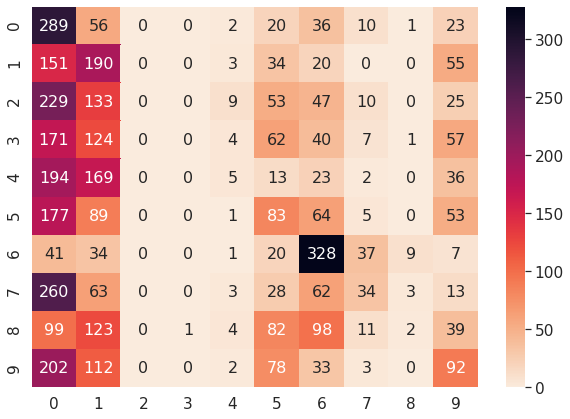

In [48]:
SEED = 123
random.seed(123)

yes_paths = glob.glob("../datasets/yes/*wav")
no_paths = glob.glob("datasets/no/*wav")

random.shuffle(yes_paths)
random.shuffle(no_paths)

print(f"Found {len(yes_paths)} 'yes' files and {len(no_paths)} 'no' files")

Found 0 'yes' files and 0 'no' files


In [241]:
n = int(2375*0.8)

yes = [create_spectrogram(file_path).flatten() for file_path in yes_paths]
no =  [create_spectrogram(file_path).flatten() for file_path in no_paths]

yes_train, yes_test = yes[:n], yes[n:]
no_train,  no_test  = no[:n],  no[n:]

X_train = []
for y, n in zip(yes_train, no_train):
    X_train.append(y)
    X_train.append(n)
X_train = np.array(X_train)
X_train = (X_train - X_train.max()/2)
X_train /= X_train.max()

y_train = np.zeros(len(X_train))
y_train[::2] = 1

X_test = np.array(yes_test + no_test)
X_test = (X_test - X_test.max()/2)
X_test /= X_test.max()
y_test = np.zeros(len(X_test))
y_test[:len(X_test)//2] = 1

In [252]:
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f"Test acc: {np.mean(preds == y_test):.4f}")

Test acc: 0.9421
